# A novel Make-Up Gain stage for the software-based Moog 4-pole audio filter (Python Demo)

Author: Jay Piamjariyakul

Supervisor: Dr. Paul Hill

Originally written in MATLAB, ported to Python

Part of the University of Bristol's EENGM8889 "Individual Research Project 4" unit
***
## Sources
### Dimensionless nonlinear digital Moog VCF difference equations:
- P. Daly, "A comparison of virtual analogue Moog VCF models," Master's thesis, Univ. ofEdinburgh, Edinburgh, UK, Aug, 2012.

### Original nonlinear VCF implementation:
- A. Huovilainen, "Non-linear digital implementation of the Moog ladder filter," in Proceed-ings of the International conference on Digital Audio Effects (DAFx-04), 2004

### Original implementation of the RLB filter:
- G. A. Soulodre, "Evaluation of objective loudness meters," in Audio Engineering SocietyConvention 116, Audio Engineering Society, 2004.

### Method for obtaining parameter values at any fs:
- D. Ward, "Applications of loudness models in audio engineering," Ph.D. dissertation, Birmingham City University, 2017

### Original parameter values for fs=48000 Hz:
- International Telecommunications Union, "ITU-R BS.1770 Algorithms to measure audioprogramme loudness and true-peak audio level," 2006

***

## 1) Preliminaries

Let us import numpy for the numerical processing. We will also import matplotlib to plot the output data, and wavfile to read input audio.

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile

Now we can define the parameters used throughout the algorithm.

Since this is a digital filter, we will require the sampling frequency and the cutoff frequency. As stated by Huovilainen, we will also define the feedback gain that gives the Moog LPF its iconic 'warmth'. We can specify the cutoff frequency and feedback gain below.

In [54]:
Fc = 440            # Cutoff frequency of Moog filter (Hz)
gainFeedbk = 3.99   # Feedback gain of Moog filter

We can now define the input. In this example let us use an impulse.


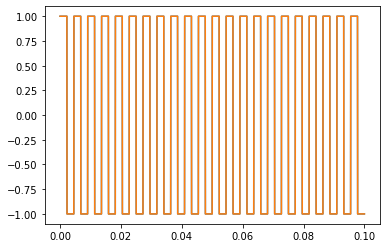

In [68]:
flag_input = "square" # Choose between ["impulse", "square", "wavfile"]
duration = 0.1   # Specify the signal duration (seconds)
Fs = 44100       # Specify the sampling frequency (Hz)
F_generate = 220 # Specify the frequency of the generated periodic signal (Hz)
# These values are redundant if wav file input specified

if (flag_input == "wavfile"):
    [Fs, in_audio] = wavfile.read("./audio_testdata/waterNight_chords_harmonics.wav")
    in_audio = np.array(in_audio, dtype=float) / (2 ** 15)
    duration = in_audio.shape[0] / Fs   # Signal duration (seconds)
    t = np.arange(0, duration, 1/Fs)    # Time array (seconds)
else:
    t = np.arange(0, duration, 1/Fs)    # Time array (seconds)
    t = t[1:] # Trims the first timestamp
    in_audio = np.zeros((t.size, 2))
    if   (flag_input == "impulse"):
        in_audio[0] = 1
    elif (flag_input == "square"):
        in_audio[:, 0] = in_audio[:, 1] = signal.square(2 * np.pi * F_generate * t)
plt.plot(t, in_audio)

We can now define the other parameters derived from the pre-defined variables shown above.


In [69]:
range_f         = np.arange(1, Fs/2)            # Frequency range of plots (half since mirror) (Hz)
range_f_norm    = range_f * (2 * np.pi) / Fs    # Normalised frequency range
# Remember: Python arrays start at 0

## 2) Runs filter on specified signal

We have to specify the weighting coefficient of the VCF as described by the following in Daly's thesis:
$$
g = 1 - e^{-2\pi (F_c/F_s)} \equiv 1 - e^{-\omega_c/F_s}
$$

In [70]:
coefWeight_vcf = 1 - np.exp( (-2 * np.pi) * ( Fc / Fs ) )
print("Weighting coefficient: {}".format(coefWeight_vcf))

Weighting coefficient: 0.06076482377125092


Let us now define the VCF function. The algorithm defined in Daly's thesis is comprised of iterative equations:
$$
y_0[n] = x[n] - \frac{k}{2} \left( y_4[n-1] + y_4[n-2] \right)
\\
y_i[n] = y_i[n-1] + g \left( \tanh(y_{i-1}[n]) - \tanh(y_{i}[n-1]) \right)
$$
where $x[n]$ is the input audio signal, $y_i[n]$ are the outputs of each Moog ladder stage (such that $i \in \{1, 2, 3, 4\}$), $g$ is the exponential weighting coefficient, and $k$ is the feedback coefficient.

In [71]:
def f_runVcf(in_audio, g, k):
    def f_vcf_nonlinear(y, in_val, g, k, y_d2):
        # Nonlinear implementation at y(4)+y_d2 uses previous value stored
        # Initial previous value (ie y_d2) = 0
        y_0 = in_val - (k * (0.5 *(y[3, :] + y_d2)))
        y[0, :] = y[0, :] + (g * (np.tanh(y_0)     - np.tanh(y[0, :]) ) )
        y[1, :] = y[1, :] + (g * (np.tanh(y[0, :]) - np.tanh(y[1, :]) ) )
        y[2, :] = y[2, :] + (g * (np.tanh(y[1, :]) - np.tanh(y[2, :]) ) )
        # Implement the delayed values, including the 'unit-and-a-half' delay as described by Daly
        y_d2    = y[3, :]
        y[3, :] = y[3, :] + (g * (np.tanh(y[2, :]) - np.tanh(y[3, :]) ) )
        
        return [y, y_d2]

    y = np.zeros((4, in_audio.shape[1]))
    y_d2 = 0
    out = np.zeros((in_audio.shape[0], 2)) # Allocates VCF output memory

    for i_sample in range(0, in_audio.shape[0] - 1):
        [y, y_d2] = f_vcf_nonlinear(y, in_audio[i_sample, :], g, k, y_d2)
        out[i_sample, :] = y[3, :]
    
    return out

Now that we have specified the input and defined the VCF function, let us run the Moog VCF on it.

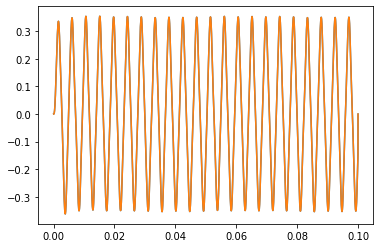

In [72]:
out_filtr = f_runVcf(in_audio, coefWeight_vcf, gainFeedbk)
plt.plot(t, out_filtr)

## 4) Runs make-up gain on filtered signal

We can now run the make-up gain algorithm on the filtered signal. Before that, however, let us define some essential functions that would implement the whole system.

Firstly, let us implement the biquad filter as described by the ITU that implements the K-filtering section. Since they are comprised of the RLB and pre-K filters, both utilising the same biquad model (as described by Ward), we can implement a template for finding their coefficients.

In [76]:
def f_getCoef_template(fil_fc, fil_q, fil_VL, fil_VB, fil_VH, Fs_filter):
    fil_Omega = np.tan(np.pi * (fil_fc / Fs_filter)) # The only fs-dependent param

    fil_coef_a = [  (fil_Omega ** 2) + (fil_Omega / fil_q) + 1, # Coefficient a0
                    2 * ((fil_Omega ** 2) - 1),                 # Coefficient a1
                    (fil_Omega ** 2) - (fil_Omega / fil_q) + 1  # Coefficient a2
                    ]

    fil_coef_b = [  (fil_VL * fil_Omega ** 2) + (fil_VB * fil_Omega / fil_q) + fil_VH, # Coefficient b0
                    2 * ((fil_VL * fil_Omega ** 2) - fil_VH),                          # Coefficient b1
                    (fil_VL * fil_Omega ** 2) - (fil_VB * fil_Omega / fil_q) + fil_VH  # Coefficient b2
                    ]

    fil_coef_b = fil_coef_b / fil_coef_a[0]; # Normalise coefficients to a0
    fil_coef_a = fil_coef_a / fil_coef_a[0]; # Normalise coefficients to a0

    return [fil_coef_b, fil_coef_a]

We can now define both RLB and pre-K filters as their own functions. Both functions call the base biquad coefficient calculation function to calculate the coefficients' values for each respective filters' parameters. The calculation process can be found in Ward's thesis.

In [77]:
# RLB filter's coefficient definitions
def f_getCoef_rlb(Fs_filter):
    fil_rlb_fc  = 38.1354709
    fil_rlb_q   = 0.5003270
    fil_rlb_VL  = 0
    fil_rlb_VB  = 0
    fil_rlb_VH  = 1.0049949
    [fil_rlb_coef_b, fil_rlb_coef_a] = f_getCoef_template(  fil_rlb_fc, fil_rlb_q,
                                                            fil_rlb_VL, fil_rlb_VB, fil_rlb_VH,
                                                            Fs_filter
                                                            )
    return [fil_rlb_coef_b, fil_rlb_coef_a]

# Pre-K filter's coefficient definitions
def f_getCoef_preK(Fs_filter):
    fil_preK_fc = 1681.9744510
    fil_preK_q  = 0.7071752
    fil_preK_VL = 1
    fil_preK_VB = 1.2587209
    fil_preK_VH = 1.5848647
    [fil_preK_coef_b, fil_preK_coef_a] = f_getCoef_template(fil_preK_fc, fil_preK_q,
                                                            fil_preK_VL, fil_preK_VB, fil_preK_VH,
                                                            Fs_filter
                                                            )
    return [fil_preK_coef_b, fil_preK_coef_a]

With this, we can now define the 1-dimensional filter's algorithm. This is a bespoke-written algorithm as, while NumPy surely offers a 1D digital filter algorithm, most of such algorithms do not offer an option (or make it non-straightforward) to also return the delay values within the filter. These delay values are essential to running the filter for consecutive digital samples.

The difference equations for a biquad digital filter are:
$$
w[n] = x[n] - a_1w[n-1] - a_2w[n-2]
\\
y[n] = b_0w[n] + b_1w[n-1] + b_2w[n-2]
$$
where $y[n]$ is the filter output, $x[n]$ is the filter input, and $w[n]$ are the internal delay values of the filter.

In [78]:
def f_1dFilter(b, a, in_audio, seq_delay):
    # MATLAB's version first maps filter coefficients to names to make it easy to understand
    # This is because MATLAB's arrays start at 1, while the coefficients (per Ward) are indexed at 0
    # However, since this is Python, this is redundant, and we can therefore use the values directly!

    out_filt = np.zeros(in_audio.shape[0]) # Instantiates output in memory

    delayNow = in_audio - (a[1] * seq_delay[0, :]) - (a[2] * seq_delay[1, :])
    out_filt = (b[0] * delayNow) + (b[1] * seq_delay[0, :]) + (b[2] * seq_delay[1, :])

    # Reassigns delay values
    seq_delay[1, :] = seq_delay[0, :]
    seq_delay[0, :] = delayNow

    return [out_filt, seq_delay]

With these preliminary steps done, we can focus on the make-up gain algorithms. The simple moving average (SMA) algorithm is implemented as a simple moving-RMS filter:
$$
l_{eq}[n] = l_{eq}[n-1]+\frac{1}{N}\left( x_w[n]^2 - x_w[n-N]^2 \right)
\\
L_{eq}[n] = 10\log_10(l_{eq}[n])
$$
where $L_{eq}[n]$ is the logarithmic loudness (in dB), $l_{eq}$ is the non-logarithmic loudness value, and $N$ is the RMS 'window' size. In practice this 'window' can be implemented as a delay line of the same sample amount. The SMA filter is considered to be an FIR filter due to having a finite 'window' length.

In [82]:
def f_makeup_sma(in_refr, out_fil, Fs_filter):
    sz_channel = in_refr.shape[1]

    # Obtain RLB & Pre-K coefficients
    [coef_rlb_b, coef_rlb_a] = f_getCoef_rlb(Fs_filter)
    [coef_prK_b, coef_prK_a] = f_getCoef_preK(Fs_filter)

    # Set necessary parameters
    size_window = round(Fs_filter * 0.4); # 0.4s from ITU document
    # Initialises output memory
    out_L_sma = np.zeros((in_refr.shape[0], sz_channel))

    # Memory of x[n] and x[n-W]
    mem_K_f = np.zeros((size_window, sz_channel))
    mem_K_i = np.zeros((size_window, sz_channel))

    # Previous loudness values
    mem_sma_L_f = np.zeros((1, sz_channel))
    mem_sma_L_i = np.zeros((1, sz_channel))

    # Memory of previous delay values in 1D filter
    delay_f_prK = np.zeros((2, sz_channel))
    delay_f_rlb = np.zeros((2, sz_channel))
    delay_i_prK = np.zeros((2, sz_channel))
    delay_i_rlb = np.zeros((2, sz_channel))
    # Stores buffer for filters

    # NB: separated assignments since Python doesn't differentate when many variables are assigned the same value

    # Run make-up gain
    for i_sample in range(0, in_refr.shape[0] - 1):
        ## 1) Obtain sequence of signals to process
        val_proc_filtr = out_fil[i_sample, :]
        val_proc_input = in_refr[i_sample, :]

        ## 2) Filter signals
        # Applies K weighting on filtered signal
        [val_proc_filtr, delay_f_prK] = f_1dFilter(coef_prK_b, coef_prK_a, val_proc_filtr, delay_f_prK)
        [val_proc_filtr, delay_f_rlb] = f_1dFilter(coef_rlb_b, coef_rlb_a, val_proc_filtr, delay_f_rlb)
        # Applies K weighting on reference signal
        [val_proc_input, delay_i_prK] = f_1dFilter(coef_prK_b, coef_prK_a, val_proc_input, delay_i_prK)
        [val_proc_input, delay_i_rlb] = f_1dFilter(coef_rlb_b, coef_rlb_a, val_proc_input, delay_i_rlb)
        # Processes the first and final values of 'window'
        mem_K_f = np.append(mem_K_f[1:, :], np.reshape(val_proc_filtr, (1, 2)), axis=0)
        mem_K_i = np.append(mem_K_i[1:, :], np.reshape(val_proc_input, (1, 2)), axis=0)

        ## 3) Calculate Leq values        
        mem_sma_L_f = mem_sma_L_f + ((mem_K_f[-1, :] ** 2) - (mem_K_f[0, :] ** 2))/size_window
        mem_sma_L_i = mem_sma_L_i + ((mem_K_i[-1, :] ** 2) - (mem_K_i[0, :] ** 2))/size_window
        Leq_filtr = mem_sma_L_f
        Leq_input = mem_sma_L_i
        # Converts linear value to LOG
        log_L_filtr = 10 * np.log10(Leq_filtr)
        log_L_input = 10 * np.log10(Leq_input)

        # Standard "ITU-R BS.1770-3" requires subtracting these LOG vals with –0.691
        # However, we intend to subtract the values together, so this becomes redundant

        ## 4) Calculate the correcting gain
        # Find the error value
        err_L = log_L_input - log_L_filtr
        # Converts err value to gain
        gain_corrector = 10 ** (err_L/20)
        gain_corrector = np.real(gain_corrector)

        ## 5) Corrects value
        # Corrects NaN values - set to zero
        gain_corrector[np.isnan(gain_corrector)] = 0
        # Prevents infinite gain - set to max floating point
        gain_corrector[np.isinf(gain_corrector)] = np.sign(gain_corrector[np.isinf(gain_corrector)]) * 1000000
        # Or a really large number!

        ## 6) Apply gain to delayed filter output at sample n
        out_now = out_fil[i_sample, :] * gain_corrector # Get current output
        out_L_sma[i_sample, :] = out_now

    return out_L_sma

A similar (albeit fundamentally different calculations-wise) algorithm using the exponential moving average filter (EMA) of time constant 125ms (per ITU and EBU) can also be implemented using the following equations:
$$
l_\tau[n] = \alpha x_w[n]^2 + (1-\alpha)l_\tau[n-1]
\\
L_\tau[n] = 10\log_10(l_\tau[n])
$$
where $\tau$ denotes the time constant of the exponential weighting coefficient $\alpha$, which is defined as:
$$
\alpha = 1 - e^{-1/(f_s\tau)}
$$
where $f_s$ is the samplig frequency. Since this results in an infinite 'window' length, the EMA filter is classified as an IIR filter.

In [83]:
def f_makeup_ema(in_refr, out_fil, Fs_filter):
    sz_channel = in_refr.shape[1]

    # Obtain RLB & Pre-K coefficients
    [coef_rlb_b, coef_rlb_a] = f_getCoef_rlb(Fs_filter)
    [coef_prK_b, coef_prK_a] = f_getCoef_preK(Fs_filter)

    # Set necessary parameters
    const_ema = 0.125 # Time constant of EMA
    coef_ema = 1 - np.exp(-1 / (Fs_filter * const_ema))
    # Initialises output memory
    out_L_ema = np.zeros((in_refr.shape[0], sz_channel))

    # Previous loudness values
    mem_ema_L_f = np.zeros((1, sz_channel))
    mem_ema_L_i = np.zeros((1, sz_channel))

    # Memory of previous delay values in 1D filter
    delay_f_prK = np.zeros((2, sz_channel))
    delay_f_rlb = np.zeros((2, sz_channel))
    delay_i_prK = np.zeros((2, sz_channel))
    delay_i_rlb = np.zeros((2, sz_channel))
    # Stores buffer for filters

    # Run make-up gain
    for i_sample in range(0, in_refr.shape[0] - 1):
        ## 1) Obtain sequence of signals to process
        val_proc_filtr = out_fil[i_sample, :]
        val_proc_input = in_refr[i_sample, :]

        ## 2) Filter signals
        # Applies K weighting on filtered signal
        [val_proc_filtr, delay_f_prK] = f_1dFilter(coef_prK_b, coef_prK_a, val_proc_filtr, delay_f_prK)
        [val_proc_filtr, delay_f_rlb] = f_1dFilter(coef_rlb_b, coef_rlb_a, val_proc_filtr, delay_f_rlb)
        # Applies K weighting on reference signal
        [val_proc_input, delay_i_prK] = f_1dFilter(coef_prK_b, coef_prK_a, val_proc_input, delay_i_prK)
        [val_proc_input, delay_i_rlb] = f_1dFilter(coef_rlb_b, coef_rlb_a, val_proc_input, delay_i_rlb)

        ## 3) Finds EMA sequence & stores them
        # Finds EMA of filtr
        mem_ema_L_f = (coef_ema * (val_proc_filtr ** 2)) + ((1 - coef_ema) * mem_ema_L_f)
        # Finds EMA of input
        mem_ema_L_i = (coef_ema * (val_proc_input ** 2)) + ((1 - coef_ema) * mem_ema_L_i)
        # Converts vals to log form
        log_L_filtr = 10 * np.log10(mem_ema_L_f)
        log_L_input = 10 * np.log10(mem_ema_L_i)

        # Standard "ITU-R BS.1770-3" requires subtracting these LOG vals with –0.691
        # However, we intend to subtract the values together, so this becomes redundant

        ## 4) Calculate the correcting gain
        # Find the error value
        err_L = log_L_input - log_L_filtr
        # Converts err value to gain
        gain_corrector = 10 ** (err_L / 20)

        ## 5) Corrects value
        # Corrects NaN values - set to zero
        gain_corrector[np.isnan(gain_corrector)] = 0
        # Prevents infinite gain - set to max floating point
        gain_corrector[np.isinf(gain_corrector)] = np.sign(gain_corrector[np.isinf(gain_corrector)]) * 1000000
        # Or a really large number!

        ## 6) Apply gain to delayed filter output at sample n
        out_now = out_fil[i_sample, :] * gain_corrector # Get current output
        out_L_ema[i_sample, :] = out_now
    
    return out_L_ema

The algorithms' outputs can be obtained and plotted as shown below:

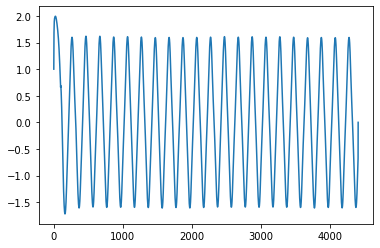

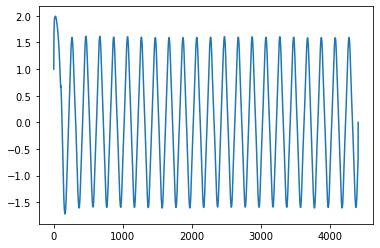

In [85]:
out_L_sma = f_makeup_sma(in_audio, out_filtr, Fs) # Make-up gain using SMA
plt.plot(out_L_sma[:, 0])
plt.show()

out_L_ema = f_makeup_ema(in_audio, out_filtr, Fs) # Make-up gain using EMA
plt.plot(out_L_ema[:, 0])
plt.show()

We have now completed the make-up gain implementation.

It is observed that, while both methods are fast, the SMA method's runtimes exceed the duration of the audio. This makes it inappropriate to be used in real-time implementation. On the other hand, the EMA method takes less time, if not equal time, to the audio duration, making it more suitable to be implemented in real-time.

## To-Do

- ~~Include method of reading wave files~~ DONE!
- Add widgets for selecting input type & changing its parameters
- Implement the improvements stated in the thesis
- Implement a file selection widget on this notebook
- Implement a gating functionality (described in ITU-R BS.1770-3)
- Implement the algorithm as a EuroRack module (IE FPGA, Arduino, or RaspberryPi)
- Improvements..? (do let me know!)